In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm

## PDF

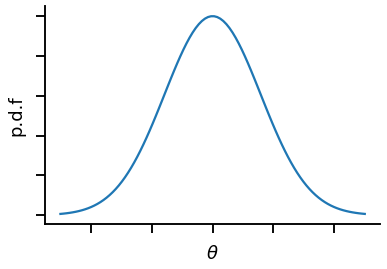

In [22]:
x = np.linspace(-5, 5, 100)
y = np.exp(-x**2/5)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()

    ax.plot(x, y)
    ax.tick_params(labelbottom=None, labelleft=None)
    ax.set_ylabel(r'p.d.f', labelpad=20)
    ax.set_xlabel(r'$\theta$', labelpad=20)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.savefig('example_pdf.pdf', bbox_inches='tight')

## Sensitivity

In [164]:
np.random.seed(42)
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector


# Define the true covariance function and its parameters
l_true = 1
η_true = 0.5
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, l)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

σ_true = 0.1
y = f_true +  np.random.normal(0, σ_true, size=n)


In [175]:
preds = []
l_mults = [1, 3]

for l_mult in l_mults:
    with pm.Model() as model:
        l = l_mult*l_true
        η = η_true

        cov = η ** 2 * pm.gp.cov.ExpQuad(1, l)
        gp = pm.gp.Marginal(cov_func=cov)

        sigma = pm.HalfCauchy("sigma", beta=5)
        y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

        mp = pm.find_MAP()

        y_pred, _ = gp.predict(X, point=mp)
        preds.append(y_pred)

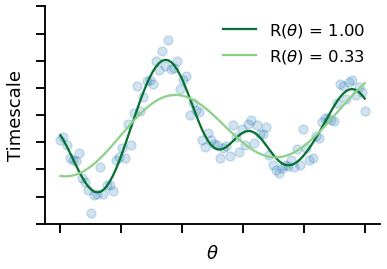

In [192]:
with sns.plotting_context('talk'):
    
    fig, ax = plt.subplots()
    cols = sns.color_palette('Greens_r')
                            
                            
    ax.scatter(X, y, marker='o', alpha=0.2)
    # ax.plot(X, f_true, color='k')
    for i, y_pred in enumerate(preds):
        
        l = l_true*l_mults[i]
        R = 1/l
    
        ax.plot(X, y_pred, color=cols[3*i],  label=fr"R($\theta$) = {R:4.2f}")   

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.tick_params(labelbottom=False, labelleft=False)
    
    ax.set_ylabel('Timescale', labelpad=20)
    ax.set_xlabel(r'$\theta$', labelpad=20)
    
    ax.set_ylim(-1, 1)
    ax.legend(frameon=False)
    plt.savefig('sensitivity_example.pdf', bbox_inches='tight')
    

## Bayes optimisation

In [280]:
np.random.seed(2)
keep_ix =  np.random.random(X.shape[0]) > 0.9

with pm.Model() as model:
    l = 1*l_true
    η = η_true

    cov = η ** 2 * pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X[keep_ix, :], y=y[keep_ix], noise=sigma)

    mp = pm.find_MAP()

    y_pred, var_pred = gp.predict(X, point=mp, diag=True, pred_noise=True)


In [281]:
from scipy.stats import norm

cdf = norm.cdf
pdf = norm.pdf

sigma = np.sqrt(var_pred)

z = (y_pred - np.max(y_pred))/np.sqrt(var_pred)


ei = sigma*(z*cdf(z) + pdf(z))

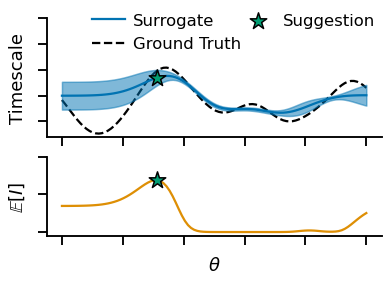

In [330]:
with sns.plotting_context('talk'):
    cols = sns.color_palette('colorblind', 4)
    
    
    fig = plt.figure(constrained_layout=False)
    ax_dict = fig.subplot_mosaic([['upper'], ['lower']], gridspec_kw={"height_ratios": [3, 2]},)
    
    ax = ax_dict['upper']
    ax2 = ax_dict['lower']
    axes = [ax, ax2]
    
    
    ax.fill_between(X.flatten(), y_pred-var_pred, y_pred+var_pred, 
                   alpha=0.5, color=cols[0], zorder=2)
    ax.plot(X.flatten(), y_pred, color=cols[0], label='Surrogate', zorder=2)
    ax.plot(X.flatten(), f_true, color='k', label='Ground Truth', ls='dashed', zorder=1)
    

    ax2.plot(X.flatten(), ei, color=cols[1])
    
    best_ix = np.argmax(ei)
    
    ax2.scatter(X[best_ix], ei[best_ix], marker='*', color=cols[2], edgecolor='k', s=300, zorder=3)
    ax.scatter(X[best_ix], y_pred[best_ix], marker='*', color=cols[2], edgecolor='k', s=300, zorder=4, label='Suggestion')
    
    for a in axes:
        a.tick_params(labelbottom=False, labelleft=False)
        a.tick_params(labelbottom=False, labelleft=False)
        a.spines.right.set_visible(False)
        a.spines.top.set_visible(False)
    
    
    ax2.set_xlabel(r"$\theta$", labelpad=20)
    ax2.set_ylabel(r'$\mathbb{E}[I]$', labelpad=20)
    
    ax.set_ylabel('Timescale', labelpad=20)
    ax.legend(bbox_to_anchor=(1, 1.1), loc='upper right', frameon=False, ncol=2, 
              columnspacing=0, handletextpad=0.5, borderaxespad=0)
    
    
    ax.set_ylim(-0.8, 1.5)
    ax2.set_ylim(-0.01, 0.2)
    plt.savefig('bayes_opt_explainer.pdf', bbox_inches='tight')